In [13]:
import librosa
import numpy as np
import pandas as pd
import math
import os
import IPython.display as ipd
import pandas as pd



# 1. Load Dataset and Extract Annotations 

In [14]:
## Dataset folders
data_root = "/homes/alb30/datasets/"
smt_guitar_root = data_root + "IDMT-SMT-GUITAR/"

In [15]:
from src.data_preparation import SMTGuitar 
# Initialise Dataset Handler
smt_guitar = SMTGuitar(data_root)

In [16]:
# Load data (in case it has been previously processed)
data_loaded = smt_guitar.load_data(path='data/')
# If there is no data
if not data_loaded[0]:
    # Extract samples from audio files
    smt_guitar.extract_audio()
    # Extract sample level annotations
    smt_guitar.extract_annotations()
    # Extract transcription mask (for each different label)
    smt_guitar.extract_transcript()

Data loaded successfully


In [17]:
# If data has not been loaded
if not data_loaded[0]:
    # Extact simple binarymask for testing purposes (with expression/without expression)
    smt_guitar.get_simple_transcript()
    # Save data
    smt_guitar.save_data(path='data/')

## Check random sample from annotations/data
Instead of plotting all the annotations we will use our 'simple' transcript that only differentiates between expressive style and lack of expression (normal)

Number of mono clips: 135


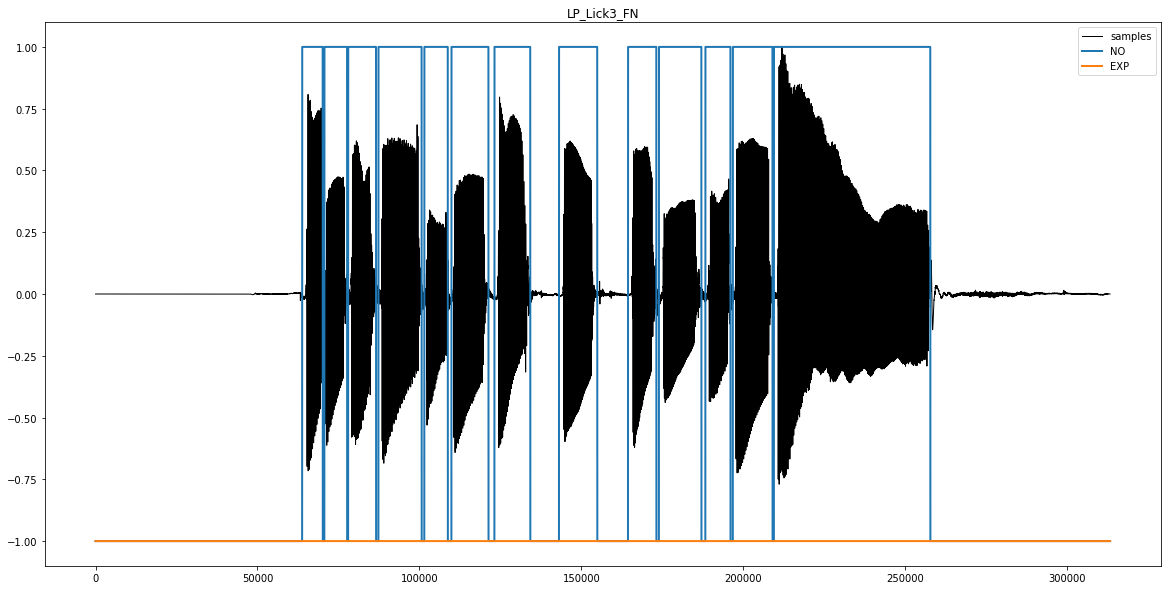

In [18]:
from random import randint
# Get all mono clips
mono_clips = smt_guitar.filter_by({'mono': True})
print("Number of mono clips:", len(mono_clips))
# Sample a random lick from the list
link = mono_clips.sample(n=1) 
idx = link.index[0]
# Plot lick and annotations
smt_guitar.plot_annotations(idx=idx, simple=True)
# Play audio
ipd.Audio(**smt_guitar.play_data(idx=idx))

In [19]:
mono_clips = smt_guitar.filter_by({'mono': True})
print("Total number of mono recordings:", len(mono_clips))

Total number of mono recordings: 135


In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load train and test data from arrays
(in case it has already been extracted)

In [21]:
ws=[512, 1024, 2048, 4096, 8192, 16384]

train_data_folder = 'data/'
X_train_data =[]
X_test_data = []

y_train = np.load(train_data_folder+'y_train.npy')
y_test = np.load(train_data_folder+'y_test.npy')

for idx in range(len(ws)):
    X_train_data.append(np.load(train_data_folder+str(idx)+'_train_mel.npy'))
    X_test_data.append(np.load(train_data_folder+str(idx)+'_test_mel.npy'))
    
train_data_loaded=False

# Sanity check: is there a file for each window?
if(len(X_train_data) == len(ws)):
    train_data_loaded=True

## If there is no data to load:
### 1. Extract features (mel spectrograms)

In [22]:
from src.feature_extraction import compute_mel_spectrograms 
import src.utils as utils 
mono_df = smt_guitar.filter_by({'mono': True})
mono_mel_spec_pkl = 'mono_mel_spec.pkl'

if not train_data_loaded:
    # Extract mel spectrograms
    mel_loaded, mel_spectrograms = utils.load_dataframe(mono_mel_spec_pkl, path='data/')
    # mel_loaded = False
    if not mel_loaded:
        print('Compute Mel spectrograms')
        mel_spectrograms = compute_mel_spectrograms(mono_df)
        mel_spectrograms.to_pickle('data/'+mono_mel_spec_pkl)


### 2. Get stack of one-hot labels and their correspondig weights

Here, we extract all labels that are present within the sample level annotations to create a set of weak labels per example

In [23]:
# Get stack of one-hot labels and label weights
from src.data_preparation import get_one_hot_labels
from src.data_preparation import get_clip_labels 
if not train_data_loaded:
    label_dataframe = get_clip_labels(mono_df, exp=smt_guitar.styles['expression'])
    one_hot_labels, label_weights = get_one_hot_labels(label_dataframe)
    np.save(train_data_folder+'label_weights', label_weights, allow_pickle=True)
    
    print(label_weights)

### 3. Pad spectrograms so that all of them have the same dimensionality

In [24]:
from src.feature_extraction import zero_pad_spectrograms 

if not train_data_loaded:
    # Pad spectrograms to retain dimensiononality
    spectrograms = zero_pad_spectrograms(mel_spectrograms)

### 4. Split in test and train sets

In [25]:
from sklearn.model_selection import train_test_split

if not train_data_loaded:

    ## Create train and test sets
    train_sets = list()
    test_sets = list()

    # Split for one the first set of spectrograms
    X_train, X_test, y_train, y_test = train_test_split(spectrograms[0], np.array(one_hot_labels))

    train_sets.append(X_train)
    test_sets.append(X_test)

    train_indices = X_train.index
    test_indices = X_test.index

    for idx, spec in enumerate(spectrograms[1:]):
            train_sets.append(pd.DataFrame(spec, index=train_indices))
            test_sets.append(pd.DataFrame(spec, index=test_indices))

    # Sanity check
    print('Training examples:', len(X_train))
    print('.....Num features', X_train.values[0][0].shape[1])
    print('.....Num frames', X_train.values[0][0].shape[0])

    print('Test examples:', len(X_test))
    print('.....Num features', X_test.values[0][0].shape[1])
    print('.....Num frames', X_test.values[0][0].shape[0])

### 5. Standardize spectrograms  & Reshape vectors for Network 
(based on train set)

In [26]:
from src.feature_extraction import standardize_spectrogram 
from src.feature_extraction import prepare_input_dimensions

if not train_data_loaded:

    X_train_std, scaler = standardize_spectrogram(X_train)
    X_test_std, _ = standardize_spectrogram(X_test, scaler)

    X_train_std_format = prepare_input_dimensions(X_train_std)
    X_test_std_format = prepare_input_dimensions(X_test_std)

    std_train_sets = []
    format_train_sets = []

    std_test_sets = []
    format_test_sets = []

    std_train_sets.append(X_train_std)
    format_train_sets.append(X_train_std_format)

    std_test_sets.append(X_test_std)
    format_test_sets.append(X_test_std_format)



    for idx, spec in enumerate(spectrograms[1:]):
        _train_std, _scaler = standardize_spectrogram(train_sets[idx])
        _test_std, _ = standardize_spectrogram(test_sets[idx], _scaler)

        std_train_sets.append(_train_std)
        format_train_sets.append( prepare_input_dimensions(_train_std) )

        std_test_sets.append(_test_std)
        format_test_sets.append( prepare_input_dimensions(_test_std) )

### 6. Save data

In [27]:
if not train_data_loaded:

    X_train_data = format_train_sets
    X_test_data = format_test_sets

    train_data_folder = 'data/'
    for idx, spec in  enumerate(spectrograms):
        test_fname = str(idx)+'_test_mel'
        train_fname = str(idx)+'_train_mel'

        np.save(train_data_folder+test_fname, X_train_data, allow_pickle=True)
        np.save(train_data_folder+test_fname, X_test_data, allow_pickle=True)

    np.save(train_data_folder+'y_train', y_train, allow_pickle=True)
    np.save(train_data_folder+'y_test', y_test, allow_pickle=True)


## Prototype network

In [28]:
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Input

/homes/alb30/venv_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/alb30/venv_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/alb30/venv_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/alb30/venv_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [34]:
ws=[512, 1024, 2048, 4096, 8192, 16384]

n_features = X_train_data[0].shape[1]
n_frames = X_train_data[0].shape[2]

input_shape = (n_features, n_frames, 1)

print('Input shape', input_shape)

inputs = []
for i, ts in enumerate(ws):
    name = 'input_'+str(i)
    inputs.append(Input(input_shape, name=name))

Input shape (128, 782, 1)


In [35]:
from src.models import *

In [37]:
early_convolutions = []
ec_outputs = []
for idx, inpt in enumerate(inputs):
    early_convolutions.append(EarlyConvolution(inpt, name=str(ws[idx])+'_'))
    early_convolutions[idx].define_layers()
    ec_outputs.append(early_convolutions[idx].output_layer)

In [38]:
late_convolution = LateConvolution(input_layers=ec_outputs)
lc_output = late_convolution.define_layers()

In [39]:
recurrent = Recurrent(input_layer=lc_output, seq_len=n_frames)
re_output = recurrent.define_layers()

In [40]:
classifier = Classifier(input_layer=recurrent.output_layer)
cl_output = classifier.define_layers()

In [41]:
model = Model(inputs=inputs, outputs=classifier.output_layer)
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 128, 782, 1)  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 128, 782, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 782, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 128, 782, 1)  0                                            
____________________________________________________________________________________________

## Attempt to load trained Multi-resolution model

In [43]:
def load_theano_model(fp):
    with np.load(fp) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    return param_values

clip2frame_model_path = 'models/model.20160309_111546.npz'
c2f_model = load_theano_model(clip2frame_model_path)

In [46]:
print(type(c2f_model))
for l, p in enumerate(c2f_model):
    print(l, len(p))


<class 'list'>
0 32
1 32
2 32
3 32
4 32
5 32
6 32
7 32
8 32
9 32
10 32
11 32
12 32
13 32
14 32
15 32
16 32
17 32
18 32
19 32
20 32
21 32
22 32
23 32
24 512
25 512
26 512
27 512
28 188
29 188
30 188
